In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot
import sklearn
import sklearn.preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from datetime import datetime
from numpy import concatenate
import matplotlib as mpl

4/25 meeting notes:

Try some deeper, more sophisticated architecture

unscale the output

In [2]:
#read in the data
hourly = pd.read_csv('wind_cleaned_2017_2020.csv',index_col='DATE')

In [3]:
hourly.columns

Index(['wnd_speed', 'temp_change', 'hourly_liq_depth_dim', 'liq_depth_dim',
       'fan_speed', 'fan_speed2', 'fan_speed3', 'rh_air_temp', 'rel_humiditiy',
       'min_hourly_air_temp', 'max_hourly_air_temp', 'std_hourly_air_temp',
       'std_hourly_humidity', 'air_temp', 'air_temp_2', 'air_temp_3',
       'std_hourly_air_temp_2', 'std_hourly_air_temp_3', 'wet1', 'wet2',
       'solar_rad', 'min_solar_rad', 'max_solar_rad', 'std_solar_rad',
       'surface_temp', 'std_surface_temp', 'ex_air_temp', 'ex_air_temp_2',
       'hourly_gust', 'wind_std', 'hour'],
      dtype='object')

In [4]:
split_fraction = 0.715   #train / validation split
train_split = int(split_fraction * int(hourly.shape[0]))
step = 1   #used if you want to skip hours

past = 120  #number of past hours to look at
future = 1  #how many hours in the future to predict
learning_rate = 0.001
batch_size = 32
epochs = 10

#normalize the data
def normalize(data, train_split):                 
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [5]:
hourly

,wnd_speed,temp_change,hourly_liq_depth_dim,liq_depth_dim,fan_speed,fan_speed2,fan_speed3,rh_air_temp,rel_humiditiy,min_hourly_air_temp,...,min_solar_rad,max_solar_rad,std_solar_rad,surface_temp,std_surface_temp,ex_air_temp,ex_air_temp_2,hourly_gust,wind_std,hour
DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,32,44,0,0,1070,944,928,44,403,44,...,0,0,0,44,1,46,44,61,93,0
2017-01-01 01:00:00,25,42,0,0,1068,942,925,42,417,42,...,0,0,0,42,1,44,42,49,82,1
2017-01-01 02:00:00,25,42,0,0,1067,941,925,41,424,40,...,0,0,0,41,0,42,40,53,88,2
2017-01-01 03:00:00,27,39,0,0,1065,940,924,39,428,38,...,0,0,0,39,2,43,38,56,87,3
2017-01-01 04:00:00,30,40,0,0,1064,939,923,40,420,36,...,0,0,0,36,1,41,36,61,89,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,19,113,0,0,886,1019,1185,113,721,105,...,1130,5483,794,130,8,114,105,34,54,19
2020-12-31 20:00:00,15,104,0,0,866,999,1160,105,714,105,...,559,4638,913,140,13,118,104,37,62,20
2020-12-31 21:00:00,13,98,0,0,819,957,1102,98,724,98,...,263,621,96,108,5,104,97,36,58,21


In [6]:
features = normalize(hourly.values, train_split)  #extract the features normalized
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1.870419,-0.504648,-0.068555,-0.066455,2.017964,-0.570617,-1.138990,-1.030727,-1.091170,-0.981134,...,-0.511901,-0.699647,-0.430825,-1.063830,-0.785441,-0.436868,-0.399904,1.335616,-0.036039,-1.661399
1,1.002877,-0.514622,-0.068555,-0.066455,1.998419,-0.625017,-1.169770,-1.051638,-1.024210,-1.002199,...,-0.511901,-0.699647,-0.430825,-1.082647,-0.785441,-0.445051,-0.408097,0.643284,-0.038550,-1.516924
2,1.002877,-0.514622,-0.068555,-0.066455,1.988647,-0.652218,-1.169770,-1.062093,-0.990730,-1.023265,...,-0.511901,-0.699647,-0.430825,-1.092056,-0.993876,-0.453234,-0.416289,0.874062,-0.037180,-1.372450
3,1.250746,-0.529583,-0.068555,-0.066455,1.969103,-0.679418,-1.180029,-1.083003,-0.971598,-1.044330,...,-0.511901,-0.699647,-0.430825,-1.110873,-0.577007,-0.449142,-0.424481,1.047145,-0.037409,-1.227975
4,1.622550,-0.524596,-0.068555,-0.066455,1.959331,-0.706618,-1.190289,-1.072548,-1.009861,-1.065395,...,-0.511901,-0.699647,-0.430825,-1.139099,-0.785441,-0.457325,-0.432674,1.335616,-0.036952,-1.083501


In [7]:
train_data = features.loc[0 : train_split - 1]  #split the data
val_data = features.loc[train_split:]

In [8]:
start = past + future   #set the start and end of the for looking to the future
end = start + train_split

x_train = train_data.values
y_train = features.iloc[start:end][[0]]  #get the first column (wind) as response

sequence_length = int(past / step) #used if skipping hours

In [9]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)     #set up a time series dataset

In [10]:
x_end = len(val_data) - past - future    #accounting for previous data

label_start = train_split + past + future   

x_val = val_data.iloc[:x_end].values
y_val = features.iloc[label_start:][[0]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)  #validation data set


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 120, 31)
Target shape: (32, 1)


In [11]:
y_val.shape

(9819, 1)

In [12]:
x_val.shape

(9819, 31)

In [13]:
#simple model with 32 LSTM layers

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(64)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

#set the model
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 31)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24576     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 24,641
Trainable params: 24,641
Non-trainable params: 0
_________________________________________________________________


In [23]:
#set an early stopping callback
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)


modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


#fit the model
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
776/776 [==============================] - 22s 26ms/step - loss: 0.7134 - val_loss: 0.5281

Epoch 00001: val_loss improved from inf to 0.52812, saving model to model_checkpoint.h5
Epoch 2/10
776/776 [==============================] - 20s 26ms/step - loss: 0.4916 - val_loss: 0.5144

Epoch 00002: val_loss improved from 0.52812 to 0.51440, saving model to model_checkpoint.h5
Epoch 3/10
776/776 [==============================] - 20s 26ms/step - loss: 0.4776 - val_loss: 0.5093

Epoch 00003: val_loss improved from 0.51440 to 0.50929, saving model to model_checkpoint.h5
Epoch 4/10
776/776 [==============================] - 20s 26ms/step - loss: 0.4698 - val_loss: 0.5072

Epoch 00004: val_loss improved from 0.50929 to 0.50717, saving model to model_checkpoint.h5
Epoch 5/10
776/776 [==============================] - 20s 26ms/step - loss: 0.4635 - val_loss: 0.5028

Epoch 00005: val_loss improved from 0.50717 to 0.50282, saving model to model_checkpoint.h5
Epoch 6/10
776/776 [=========

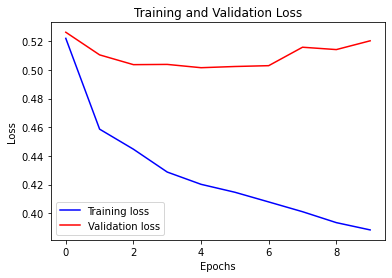

In [15]:
#visualize the loss over epochs

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

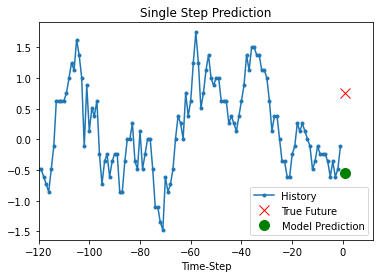

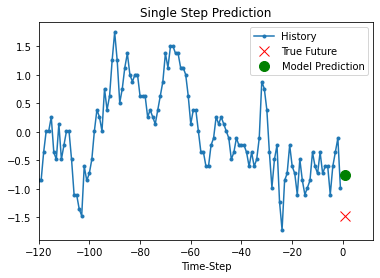

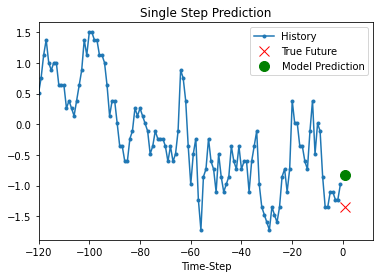

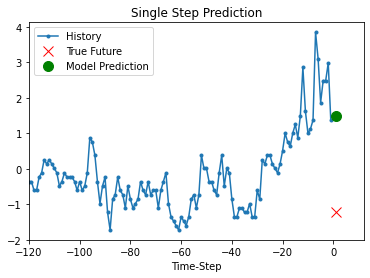

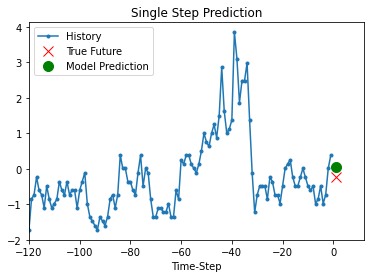

In [16]:
#function to visualize the predictions

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), model.predict(x)[0]],
        future,  
        "Single Step Prediction",
    )

In [18]:
#A modification of the initial model
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(60)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

#set the model
model2 = keras.Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 31)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                22080     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 22,141
Trainable params: 22,141
Non-trainable params: 0
_________________________________________________________________


In [19]:
#set an early stopping callback
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)


modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


#fit the model
history = model2.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
193/193 [==============================] - 7s 27ms/step - loss: 0.9018 - val_loss: 0.5654

Epoch 00001: val_loss improved from inf to 0.56542, saving model to model_checkpoint.h5
Epoch 2/10
193/193 [==============================] - 5s 27ms/step - loss: 0.6308 - val_loss: 0.5317

Epoch 00002: val_loss improved from 0.56542 to 0.53175, saving model to model_checkpoint.h5
Epoch 3/10
193/193 [==============================] - 5s 25ms/step - loss: 0.5523 - val_loss: 0.5526

Epoch 00003: val_loss did not improve from 0.53175
Epoch 4/10
193/193 [==============================] - 5s 26ms/step - loss: 0.5155 - val_loss: 0.5567

Epoch 00004: val_loss did not improve from 0.53175
Epoch 5/10
193/193 [==============================] - 5s 25ms/step - loss: 0.4946 - val_loss: 0.5867

Epoch 00005: val_loss did not improve from 0.53175
Epoch 6/10
193/193 [==============================] - 5s 25ms/step - loss: 0.4797 - val_loss: 0.5520

Epoch 00006: val_loss did not improve from 0.53175
Epoc

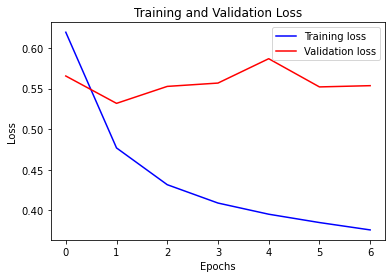

In [20]:
#visualize the loss over epochs

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

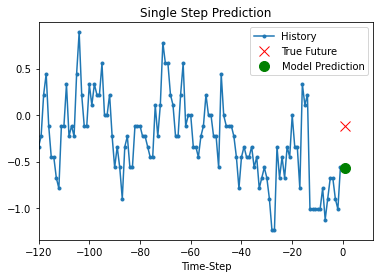

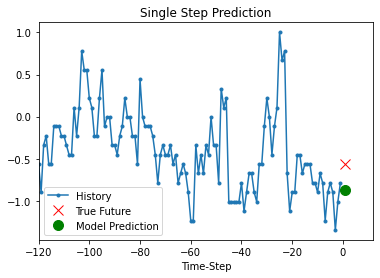

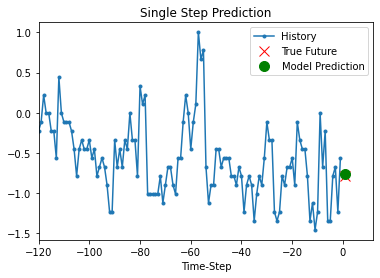

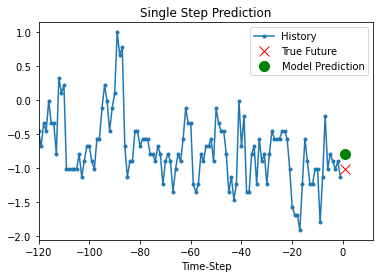

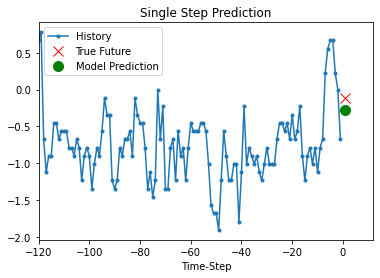

In [21]:
#function to visualize the predictions

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), model2.predict(x)[0]],
        future,  
        "Single Step Prediction",
    )

In [ ]:
#Recreating the model from https://github.com/balandhanka/Windspeed-Forecasting-LSTM-GRU/blob/master/final_lstm.ipynb

In [83]:
def create_ts_data(dataset, lookback=1, predicted_col=0):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predicted"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [84]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(features, 1,0)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)','var6(t-1)','var7(t-1)','var8(t-1)',
                      'var9(t-1)','var10(t-1)','var11(t-1)','var12(t-1)','var13(t-1)','var14(t-1)','var15(t-1)','var16(t-1)',
                      'var17(t-1)','var18(t-1)','var19(t-1)','var20(t-1)','var21(t-1)','var22(t-1)','var23(t-1)','var24(t-1)',
                      'var25(t-1)','var26(t-1)','var27(t-1)','var28(t-1)','var29(t-1)','var30(t-1)','var31(t-1)','var32(t-1)']
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
id                                                                     
1    1.870419  -0.504648  -0.068555  -0.066455   2.017964  -0.570617   
2    1.002877  -0.514622  -0.068555  -0.066455   1.998419  -0.625017   
3    1.002877  -0.514622  -0.068555  -0.066455   1.988647  -0.652218   
4    1.250746  -0.529583  -0.068555  -0.066455   1.969103  -0.679418   

    var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var23(t-1)  var24(t-1)  \
id                                               ...                           
1   -1.138990  -1.030727  -1.091170   -0.981134  ...   -0.699647   -0.430825   
2   -1.169770  -1.051638  -1.024210   -1.002199  ...   -0.699647   -0.430825   
3   -1.169770  -1.062093  -0.990730   -1.023265  ...   -0.699647   -0.430825   
4   -1.180029  -1.083003  -0.971598   -1.044330  ...   -0.699647   -0.430825   

    var25(t-1)  var26(t-1)  var27(t-1)  var28(t-1)  var29(t-1)  var30(t-1)  \
id      

In [85]:


# split into train and test sets
values = reframed_df.values
training_sample =int( len(hourly) *0.7)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]



In [86]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(24413, 1, 31) (24413,) (10462, 1, 31) (10462,)


In [87]:
model_lstm = Sequential()
model_lstm.add(LSTM(75, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=30, return_sequences=True))
model_lstm.add(LSTM(units=30))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mse', optimizer='adam')

In [88]:
model_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 1, 75)             32100     
_________________________________________________________________
lstm_19 (LSTM)               (None, 1, 30)             12720     
_________________________________________________________________
lstm_20 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 52,171
Trainable params: 52,171
Non-trainable params: 0
_________________________________________________________________


In [89]:
tf.keras.backend.clear_session()

In [90]:
lstm_history = model_lstm.fit(train_X, train_y, epochs=20,validation_data=(test_X, test_y), batch_size=64, shuffle=False,callbacks=[es_callback, modelckpt_callback])

Epoch 1/20
382/382 [==============================] - 6s 5ms/step - loss: 0.7746 - val_loss: 0.3766

Epoch 00001: val_loss did not improve from 0.03832
Epoch 2/20
382/382 [==============================] - 1s 2ms/step - loss: 0.2999 - val_loss: 0.3436

Epoch 00002: val_loss did not improve from 0.03832
Epoch 3/20
382/382 [==============================] - 1s 2ms/step - loss: 0.2881 - val_loss: 0.3358

Epoch 00003: val_loss did not improve from 0.03832
Epoch 4/20
382/382 [==============================] - 1s 2ms/step - loss: 0.2851 - val_loss: 0.3331

Epoch 00004: val_loss did not improve from 0.03832
Epoch 5/20
382/382 [==============================] - 1s 3ms/step - loss: 0.2838 - val_loss: 0.3315

Epoch 00005: val_loss did not improve from 0.03832
Epoch 6/20
382/382 [==============================] - 1s 3ms/step - loss: 0.2862 - val_loss: 0.3325

Epoch 00006: val_loss did not improve from 0.03832
Epoch 7/20
382/382 [==============================] - 1s 3ms/step - loss: 0.2823 - val_l

In [91]:
pred_y =  model_lstm.predict(test_X)

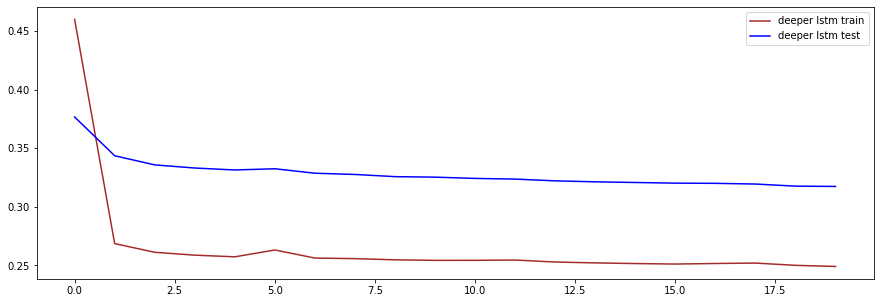

In [114]:
pyplot.plot(lstm_history.history['loss'], label='deeper lstm train', color='brown')
pyplot.plot(lstm_history.history['val_loss'], label='deeper lstm test', color='blue')
pyplot.legend()
pyplot.show()

In [93]:
test_y.reshape(10462,1)

array([[-0.85614005],
       [-0.85614005],
       [-0.98007454],
       ...,
       [-0.48433656],
       [-0.60827106],
       [-0.73220555]])

In [94]:
pred_y

array([[-0.7241635 ],
       [-0.82084334],
       [-0.77041346],
       ...,
       [-0.21456069],
       [-0.42515886],
       [-0.554922  ]], dtype=float32)

0.3174144385776666
0.7246698987428222
0.5633954548784242
0.40639637026992


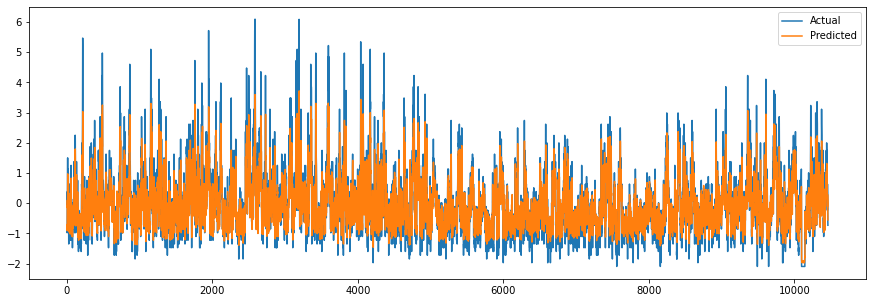

In [95]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

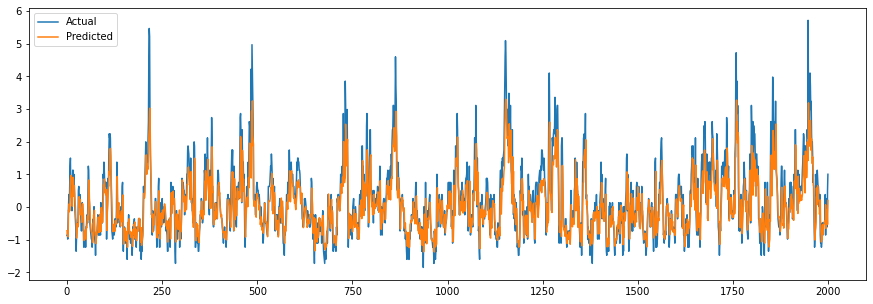

In [96]:


#over small part of data
plt.plot(test_y[:2000], label = 'Actual')
plt.plot(pred_y[:2000], label = 'Predicted')
plt.legend()
plt.show()



In [97]:
#un-standardizing the outputs?
test_y_unstd = test_y*hourly['wnd_speed'].std() + hourly['wnd_speed'].mean()

In [98]:
test_y_unstd

array([ 9.90075683,  9.90075683,  8.87869324, ..., 12.96694762,
       11.94488402, 10.92282043])

In [99]:
pred_y_unstd = pred_y*hourly['wnd_speed'].std() + hourly['wnd_speed'].mean()

In [100]:
pred_y_unstd

array([[10.989141],
       [10.191841],
       [10.607726],
       ...,
       [15.191736],
       [13.454973],
       [12.384842]], dtype=float32)

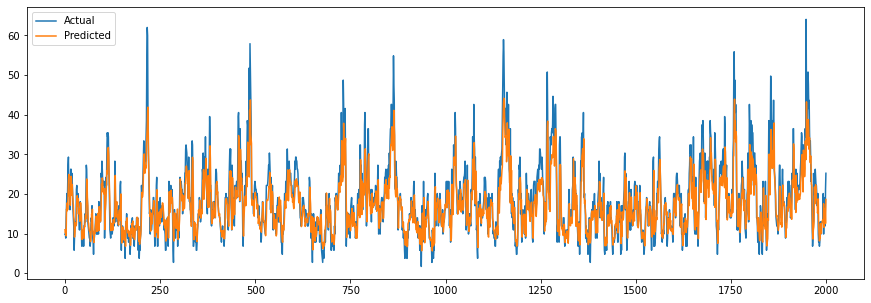

In [101]:
#over small part of data
plt.plot(test_y_unstd[:2000], label = 'Actual')
plt.plot(pred_y_unstd[:2000], label = 'Predicted')
plt.legend()
plt.show()

21.587290040358628
0.7246698902548872
4.646212440295711
3.3514715577525926


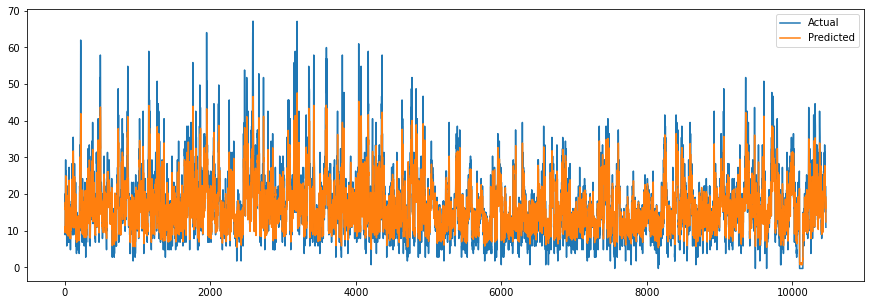

In [102]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y_unstd, pred_y_unstd)
R2 = r2_score(test_y_unstd, pred_y_unstd)
RMSE = sqrt(mean_squared_error(test_y_unstd, pred_y_unstd))
MAE = mean_absolute_error(test_y_unstd, pred_y_unstd)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y_unstd, label = 'Actual')
plt.plot(pred_y_unstd, label = 'Predicted')
plt.legend()
plt.show()

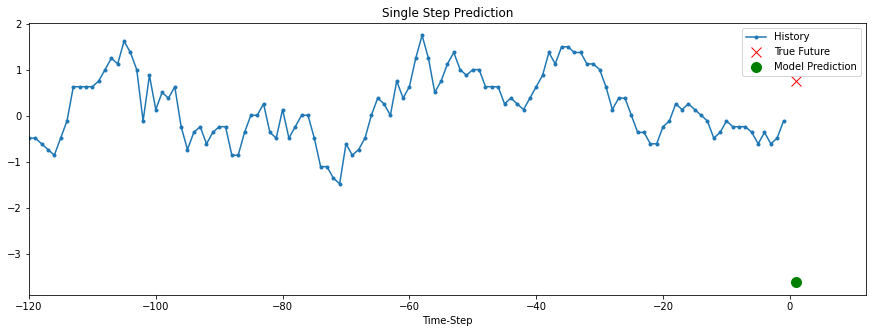

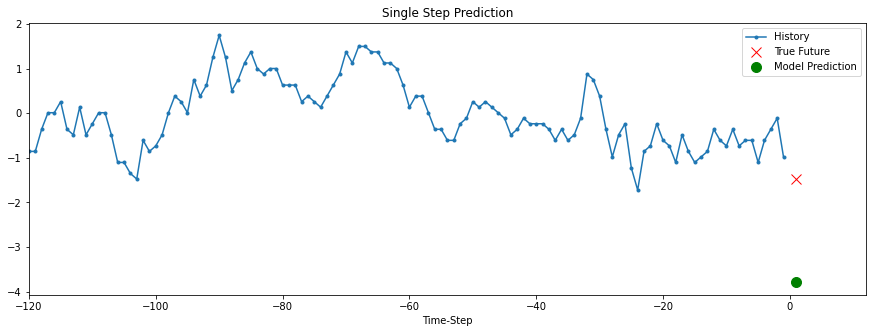

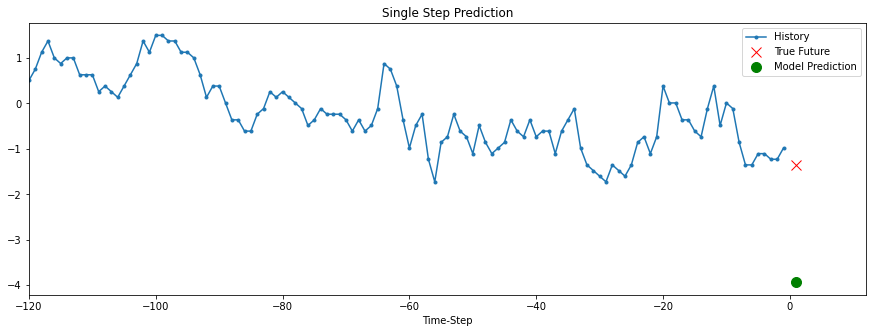

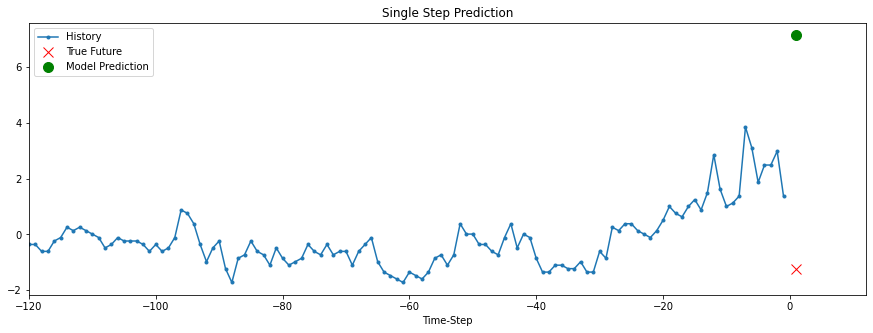

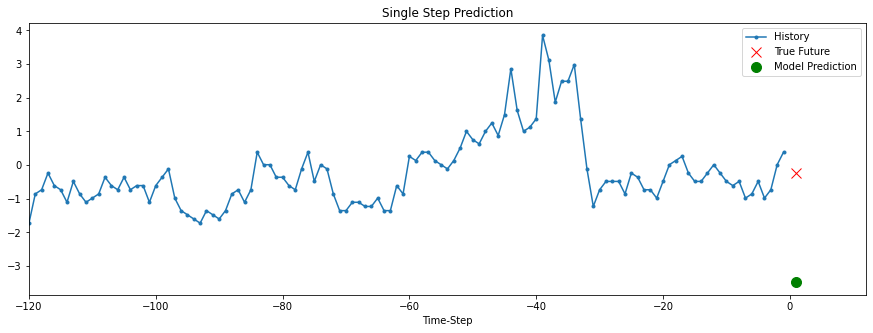

In [103]:
#function to visualize the predictions

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), model_lstm.predict(x)[0]],
        future,  
        "Single Step Prediction",
    )

In [104]:
#Making some additions to the deeper LSTM
model_lstm2 = Sequential()
model_lstm2.add(LSTM(80, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm2.add(keras.layers.BatchNormalization())
model_lstm2.add(LSTM(units=40, return_sequences=True))
model_lstm2.add(LSTM(units=40))
model_lstm2.add(Dense(units=1))

model_lstm2.compile(loss='mse', optimizer='adam')

In [105]:
lstm_history2 = model_lstm2.fit(train_X, train_y, epochs=20,validation_data=(test_X, test_y), batch_size=64, shuffle=False,callbacks=[es_callback, modelckpt_callback])

Epoch 1/20
382/382 [==============================] - 7s 5ms/step - loss: 0.7329 - val_loss: 0.5443

Epoch 00001: val_loss did not improve from 0.03832
Epoch 2/20
382/382 [==============================] - 1s 3ms/step - loss: 0.4550 - val_loss: 0.3848

Epoch 00002: val_loss did not improve from 0.03832
Epoch 3/20
382/382 [==============================] - 1s 3ms/step - loss: 0.3510 - val_loss: 0.3746

Epoch 00003: val_loss did not improve from 0.03832
Epoch 4/20
382/382 [==============================] - 1s 3ms/step - loss: 0.3224 - val_loss: 0.3787

Epoch 00004: val_loss did not improve from 0.03832
Epoch 5/20
382/382 [==============================] - 1s 3ms/step - loss: 0.3084 - val_loss: 0.3863

Epoch 00005: val_loss did not improve from 0.03832
Epoch 6/20
382/382 [==============================] - 1s 3ms/step - loss: 0.2976 - val_loss: 0.3944

Epoch 00006: val_loss did not improve from 0.03832
Epoch 7/20
382/382 [==============================] - 1s 3ms/step - loss: 0.2885 - val_l

In [106]:
pred_y2 =  model_lstm2.predict(test_X)

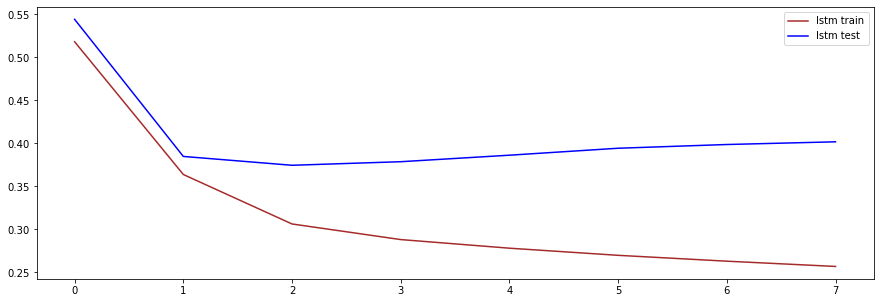

In [107]:
pyplot.plot(lstm_history2.history['loss'], label='lstm train', color='brown')
pyplot.plot(lstm_history2.history['val_loss'], label='lstm test', color='blue')
pyplot.legend()
pyplot.show()

In [109]:
test_y.reshape(10462,1)

array([[-0.85614005],
       [-0.85614005],
       [-0.98007454],
       ...,
       [-0.48433656],
       [-0.60827106],
       [-0.73220555]])

0.3174144385776666
0.7246698987428222
0.5633954548784242
0.40639637026992


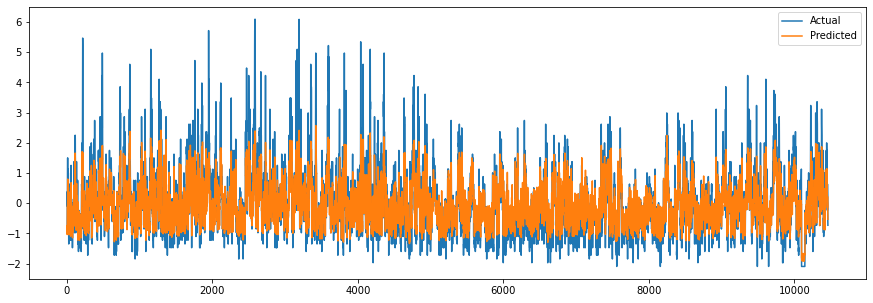

In [110]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y2, label = 'Predicted')
plt.legend()
plt.show()

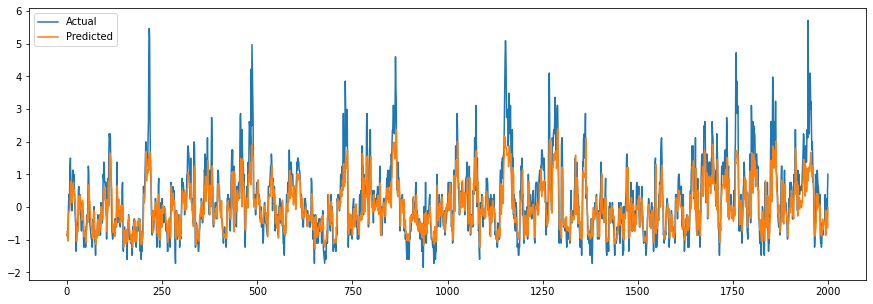

In [111]:
#over small part of data
plt.plot(test_y[:2000], label = 'Actual')
plt.plot(pred_y2[:2000], label = 'Predicted')
plt.legend()
plt.show()

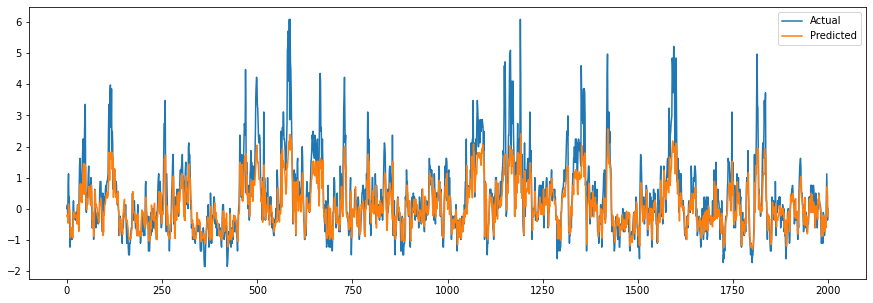

In [112]:
#over small part of data
plt.plot(test_y[2000:4000], label = 'Actual')
plt.plot(pred_y2[2000:4000], label = 'Predicted')
plt.legend()
plt.show()

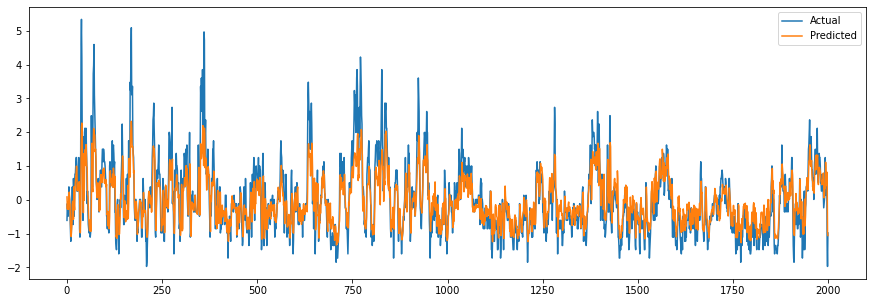

In [113]:
#over small part of data
plt.plot(test_y[4000:6000], label = 'Actual')
plt.plot(pred_y2[4000:6000], label = 'Predicted')
plt.legend()
plt.show()

In [34]:
#Recreating some of the RNNs from the M7_3 tutorial

y_pred = x_val[:, -1]
np.mean(keras.losses.mean_squared_error(y_val, y_pred))

2.164590489271398

In [35]:
#Back to basics. Let's try a simple RNN

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

modelR = keras.models.Sequential([
    keras.layers.SimpleRNN(1)
])

optimizer = keras.optimizers.Adam(lr=0.005)
modelR.compile(loss="mse", optimizer=optimizer)
historyR = modelR.fit(dataset_train, epochs=20,
                    validation_data=dataset_val)

Epoch 1/20
776/776 [==============================] - 8s 9ms/step - loss: 0.9185 - val_loss: 0.6211
Epoch 2/20
776/776 [==============================] - 7s 9ms/step - loss: 0.5991 - val_loss: 0.6168
Epoch 3/20
776/776 [==============================] - 7s 9ms/step - loss: 0.5926 - val_loss: 0.6150
Epoch 4/20
776/776 [==============================] - 7s 9ms/step - loss: 0.5905 - val_loss: 0.6150
Epoch 5/20
776/776 [==============================] - 7s 9ms/step - loss: 0.5888 - val_loss: 0.6151
Epoch 6/20
776/776 [==============================] - 7s 9ms/step - loss: 0.5875 - val_loss: 0.6146
Epoch 7/20
776/776 [==============================] - 7s 9ms/step - loss: 0.5873 - val_loss: 0.6148
Epoch 8/20
776/776 [==============================] - 7s 9ms/step - loss: 0.5872 - val_loss: 0.6148
Epoch 9/20
776/776 [==============================] - 7s 9ms/step - loss: 0.5871 - val_loss: 0.6148 - ETA: 0s - loss: 0.58
Epoch 10/20
776/776 [==============================] - 7s 9ms/step - loss: 0.

In [37]:
modelR.evaluate(dataset_val)

304/304 [==============================] - 1s 3ms/step - loss: 0.6146


0.6145708560943604

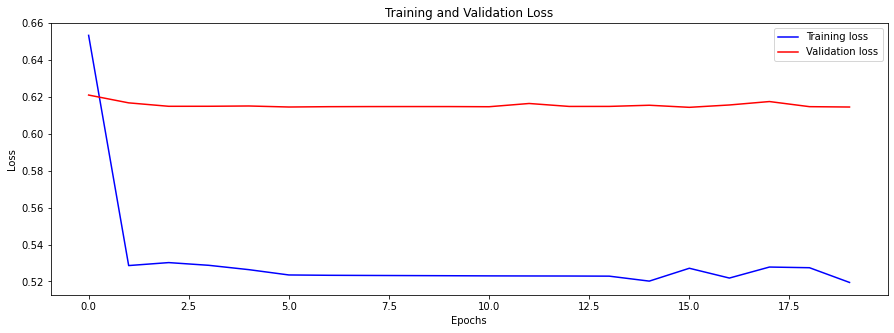

In [38]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(historyR, "Training and Validation Loss")

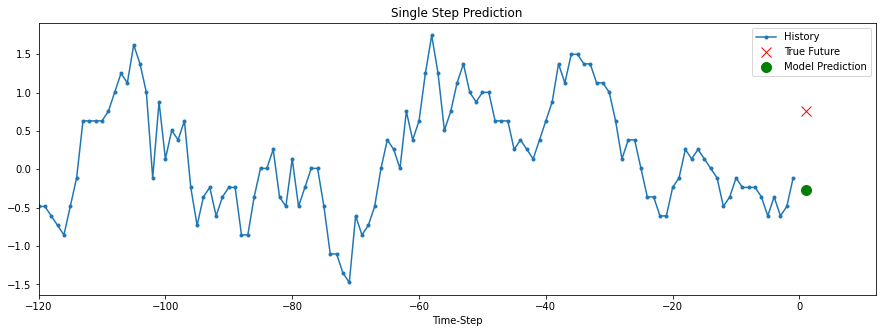

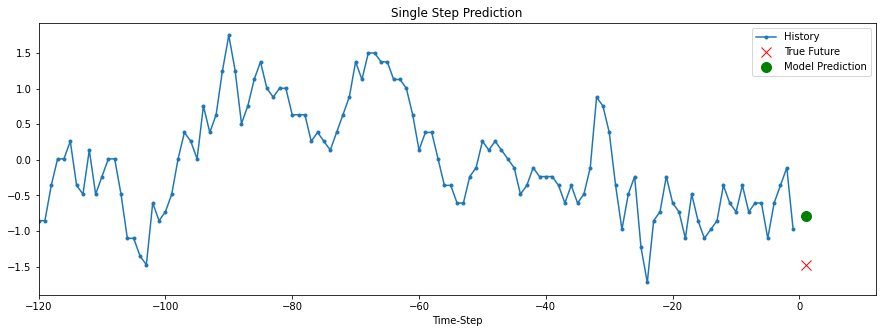

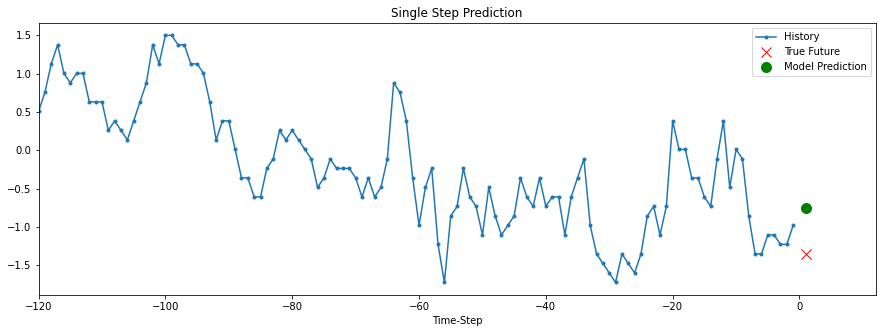

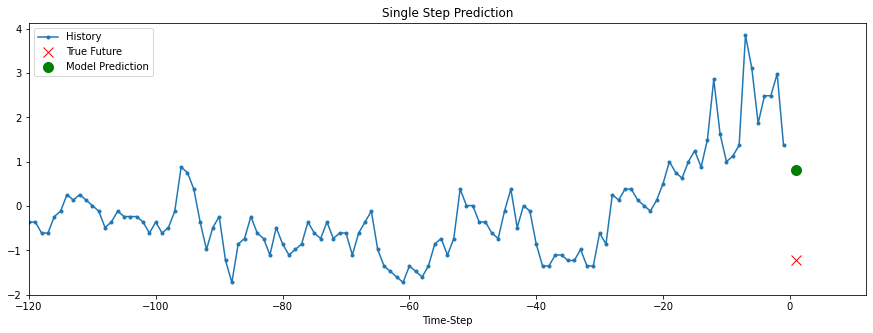

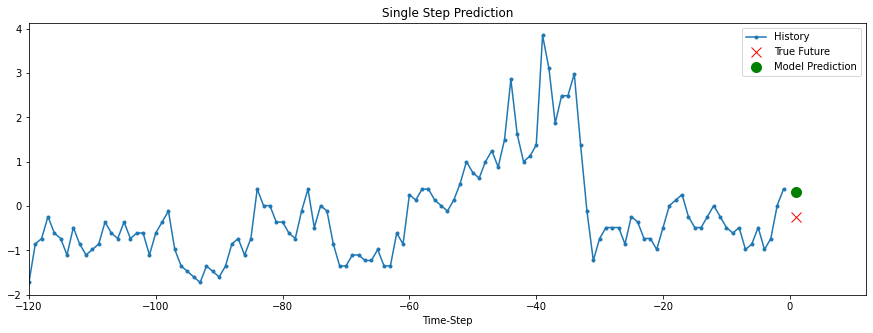

In [39]:
#function to visualize the predictions

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), modelR.predict(x)[0]],
        future,  
        "Single Step Prediction",
    )

In [40]:
#Let's try a deep rnn

np.random.seed(42)
tf.random.set_seed(42)

modelDR = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

modelDR.compile(loss="mse", optimizer="adam")
historyDR = modelDR.fit(dataset_train, epochs=20,
                    validation_data=dataset_val)

Epoch 1/20
776/776 [==============================] - 22s 26ms/step - loss: 0.9359 - val_loss: 0.6604
Epoch 2/20
776/776 [==============================] - 21s 27ms/step - loss: 0.6257 - val_loss: 0.6392
Epoch 3/20
776/776 [==============================] - 21s 27ms/step - loss: 0.6032 - val_loss: 0.6303
Epoch 4/20
776/776 [==============================] - 23s 30ms/step - loss: 0.5935 - val_loss: 0.6237
Epoch 5/20
776/776 [==============================] - 21s 27ms/step - loss: 0.5879 - val_loss: 0.6210
Epoch 6/20
776/776 [==============================] - 21s 27ms/step - loss: 0.5816 - val_loss: 0.6184
Epoch 7/20
776/776 [==============================] - 22s 29ms/step - loss: 0.5775 - val_loss: 0.6150
Epoch 8/20
776/776 [==============================] - 22s 28ms/step - loss: 0.5751 - val_loss: 0.6139
Epoch 9/20
776/776 [==============================] - 21s 27ms/step - loss: 0.5711 - val_loss: 0.6112
Epoch 10/20
776/776 [==============================] - 22s 28ms/step - loss: 0.568

In [41]:
modelDR.evaluate(dataset_val)

304/304 [==============================] - 2s 7ms/step - loss: 0.6148A: 0


0.61475670337677

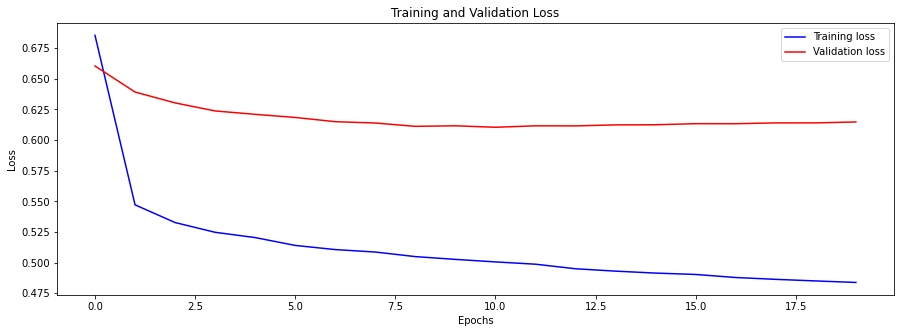

In [42]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(historyDR, "Training and Validation Loss")

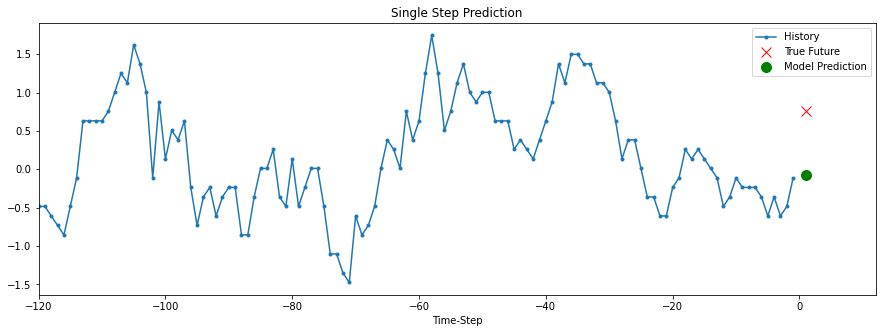

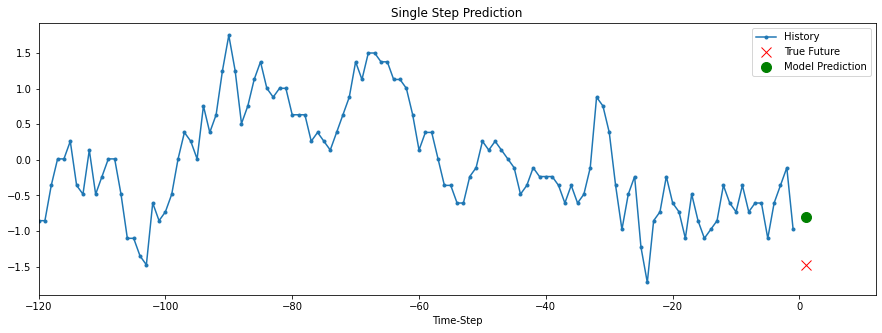

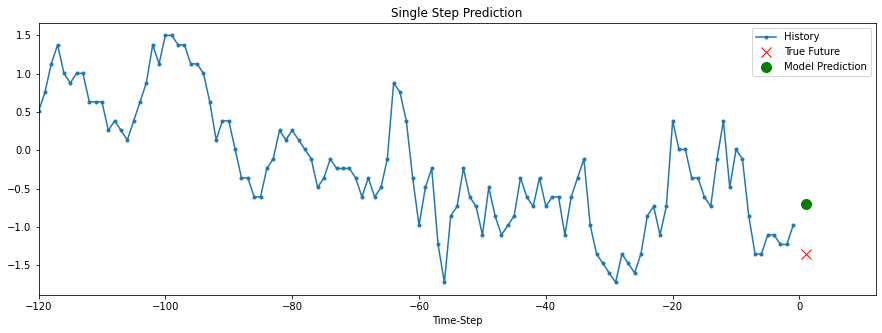

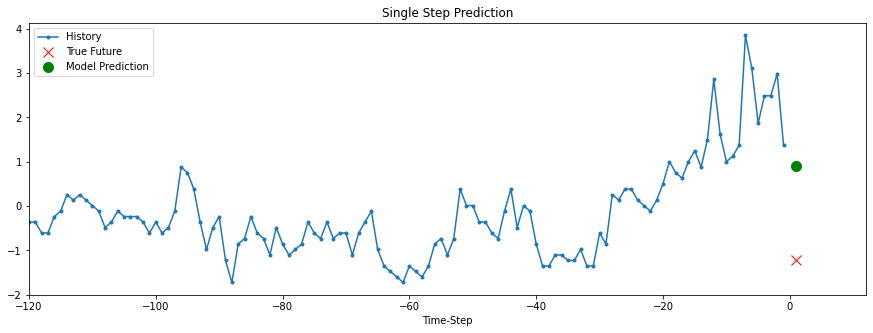

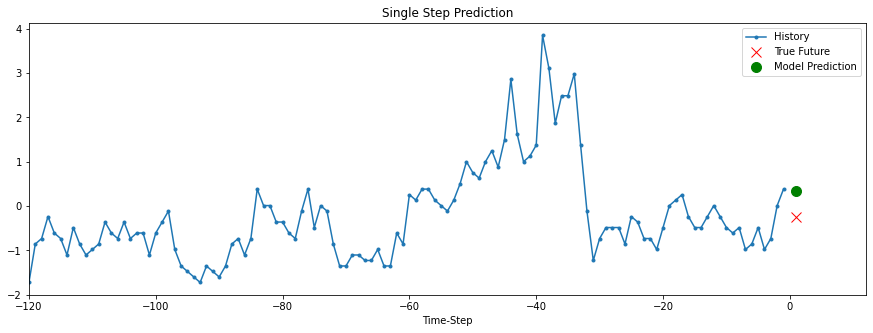

In [43]:
#function to visualize the predictions

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), modelDR.predict(x)[0]],
        future,  
        "Single Step Prediction",
    )

In [59]:
#The deep rnn structure but with LSTM
np.random.seed(42)
tf.random.set_seed(42)

modelLSTM = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(1)
])

modelLSTM.compile(loss="mse", optimizer="adam")
historyLSTM = modelLSTM.fit(dataset_train, epochs=20,
                    validation_data=dataset_val)

Epoch 1/20
193/193 [==============================] - 16s 58ms/step - loss: 1.1375 - val_loss: 0.7600
Epoch 2/20
193/193 [==============================] - 10s 52ms/step - loss: 1.0110 - val_loss: 0.7454
Epoch 3/20
193/193 [==============================] - 10s 51ms/step - loss: 0.9463 - val_loss: 0.7301
Epoch 4/20
193/193 [==============================] - 10s 52ms/step - loss: 0.8832 - val_loss: 0.7148
Epoch 5/20
193/193 [==============================] - 10s 53ms/step - loss: 0.8330 - val_loss: 0.7146
Epoch 6/20
193/193 [==============================] - 10s 52ms/step - loss: 0.7941 - val_loss: 0.7208
Epoch 7/20
193/193 [==============================] - 10s 53ms/step - loss: 0.7656 - val_loss: 0.7076
Epoch 8/20
193/193 [==============================] - 10s 51ms/step - loss: 0.7397 - val_loss: 0.6830
Epoch 9/20
193/193 [==============================] - 11s 59ms/step - loss: 0.7198 - val_loss: 0.6890
Epoch 10/20
193/193 [==============================] - 11s 55ms/step - loss: 0.701

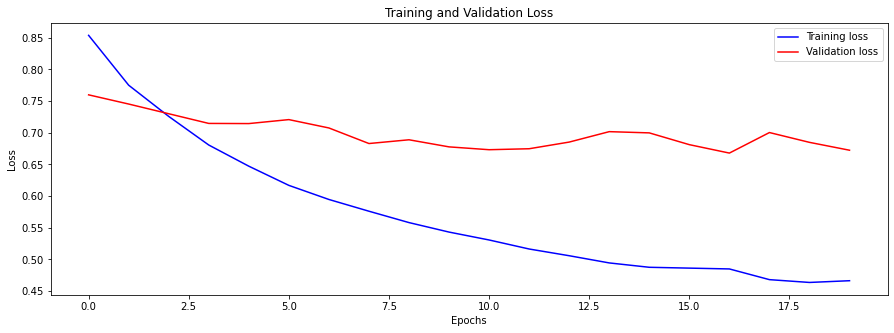

In [60]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(historyLSTM, "Training and Validation Loss")

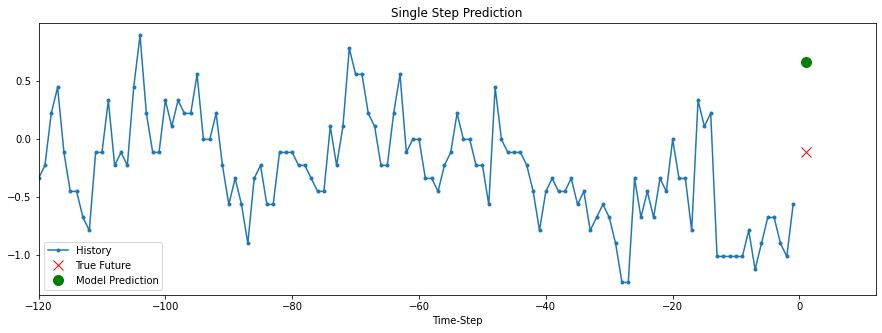

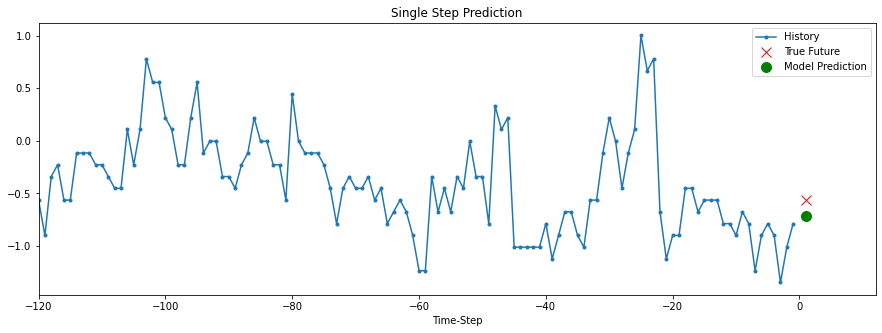

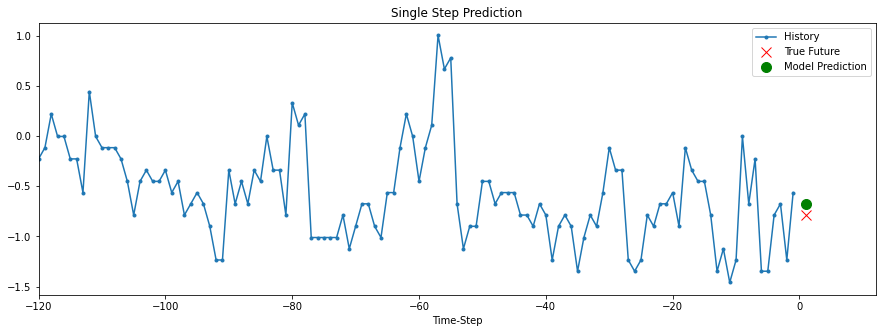

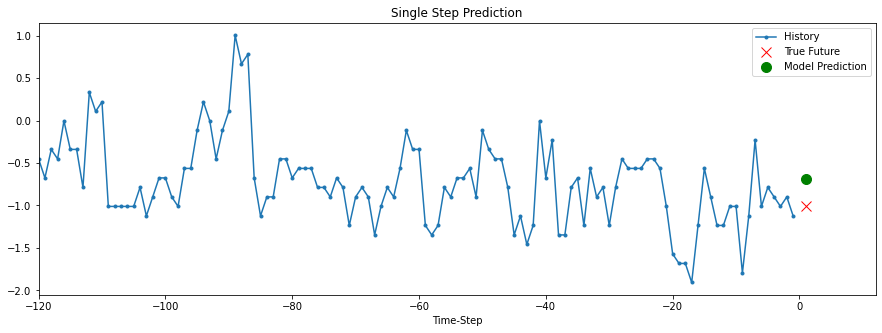

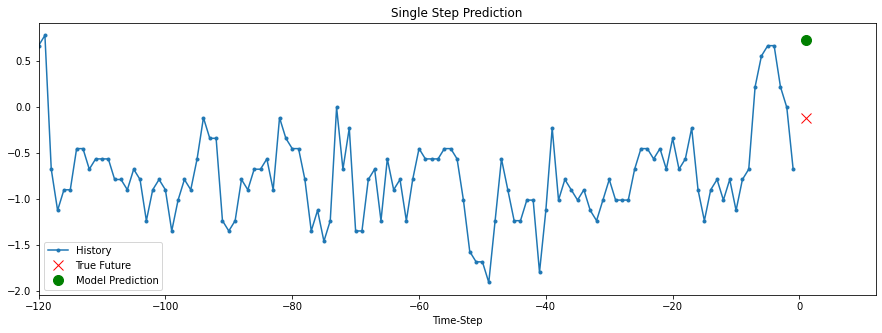

In [61]:
#function to visualize the predictions

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), modelLSTM.predict(x)[0]],
        future,  
        "Single Step Prediction",
    )

In [ ]:
#Maybe adding another layer of something to this particular model?


In [18]:
#Working through the steps presented by https://pathtopioneer.com/blog/2020/06/7-3

In [44]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [45]:
uni_data = hourly['wnd_speed']
uni_data.index = hourly.index
uni_data.head()

DATE
2017-01-01 00:00:00    32
2017-01-01 01:00:00    25
2017-01-01 02:00:00    25
2017-01-01 03:00:00    27
2017-01-01 04:00:00    30
Name: wnd_speed, dtype: int64

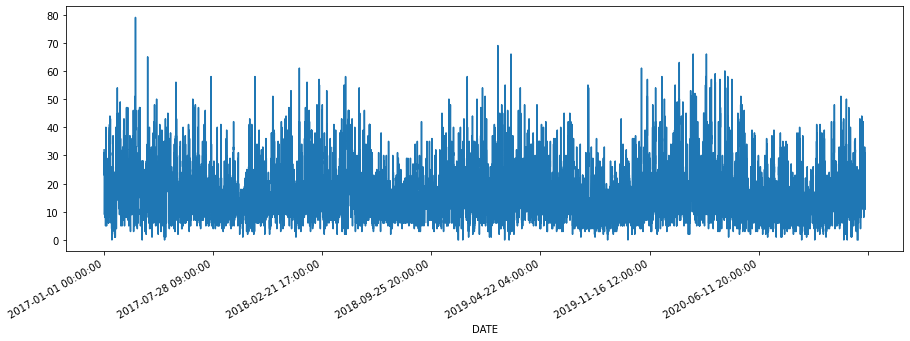

In [46]:
uni_data.plot(subplots=True)
plt.show()

In [47]:
# Extract numpy array of samples out
uni_data = uni_data.values.reshape(-1, 1)

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(uni_data[:train_split])
uni_data_scaled = scaler.transform(uni_data)

In [49]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data_scaled, 0, train_split,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data_scaled, train_split, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [50]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target wind speed to predict')
print (y_train_uni[0])

Single window of past history
[[ 1.87041884]
 [ 1.00287738]
 [ 1.00287738]
 [ 1.25074637]
 [ 1.62254985]
 [ 1.37468086]
 [ 1.25074637]
 [ 1.25074637]
 [ 0.87894288]
 [ 0.75500839]
 [ 1.74648435]
 [ 1.37468086]
 [ 1.25074637]
 [ 0.87894288]
 [ 0.13533591]
 [-0.85614005]
 [-0.85614005]
 [-0.98007454]
 [-0.73220555]
 [-0.85614005]]

 Target wind speed to predict
[-0.23646757]


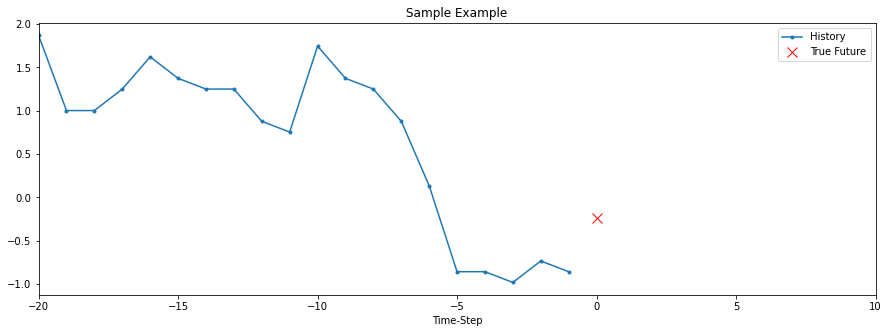

In [51]:
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(
            ), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    plt.show()

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

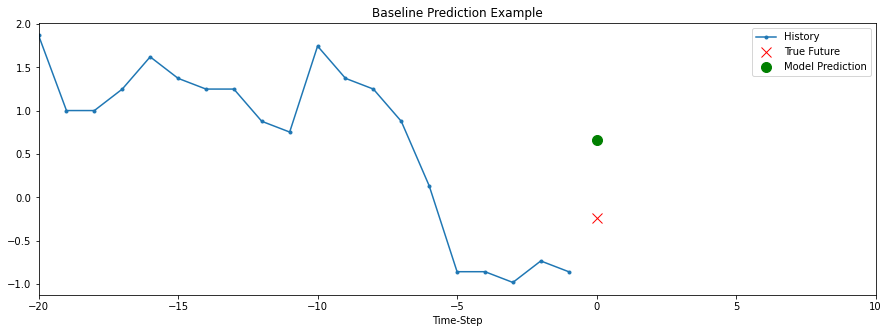

In [52]:
def baseline(history):
    return np.mean(history)


show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
          'Baseline Prediction Example')

In [53]:
#Starting the LSTM
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE)

In [54]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mae')

In [55]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [56]:
for x, y in val_univariate.take(1):
    print(model.predict(x).shape)

(256, 1)


In [57]:
EPOCHS = 200

early = tf.keras.callbacks.EarlyStopping('val_loss', patience=3)

history = model.fit(train_univariate, epochs=EPOCHS,
                    validation_data=val_univariate,
                    callbacks=[early])

Epoch 1/200
98/98 [==============================] - 2s 8ms/step - loss: 0.6174 - val_loss: 0.5414
Epoch 2/200
98/98 [==============================] - 0s 5ms/step - loss: 0.4979 - val_loss: 0.4472
Epoch 3/200
98/98 [==============================] - 0s 5ms/step - loss: 0.4201 - val_loss: 0.4141
Epoch 4/200
98/98 [==============================] - 0s 5ms/step - loss: 0.3943 - val_loss: 0.4038
Epoch 5/200
98/98 [==============================] - 0s 5ms/step - loss: 0.3879 - val_loss: 0.3995
Epoch 6/200
98/98 [==============================] - 0s 5ms/step - loss: 0.3830 - val_loss: 0.3982
Epoch 7/200
98/98 [==============================] - 0s 5ms/step - loss: 0.3824 - val_loss: 0.3977
Epoch 8/200
98/98 [==============================] - 0s 5ms/step - loss: 0.3790 - val_loss: 0.3982
Epoch 9/200
98/98 [==============================] - 0s 5ms/step - loss: 0.3837 - val_loss: 0.3965
Epoch 10/200
98/98 [==============================] - 0s 5ms/step - loss: 0.3785 - val_loss: 0.3964
Epoch 11/

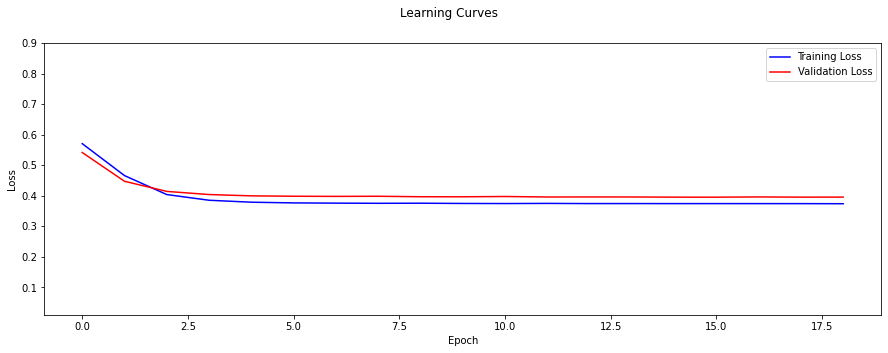

In [58]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
fig = plt.Figure(figsize=(15, 8))

epochs_to_mean = 1

plt.plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
plt.plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
plt.suptitle('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("Epoch")
plt.ylim(0.01, 0.9)
plt.ylabel("Loss")
plt.show()

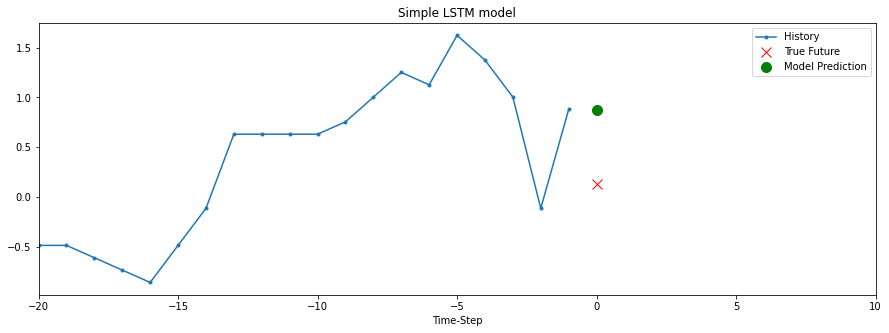

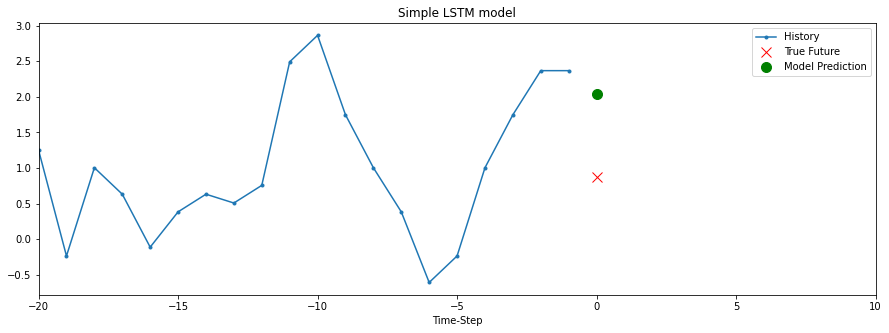

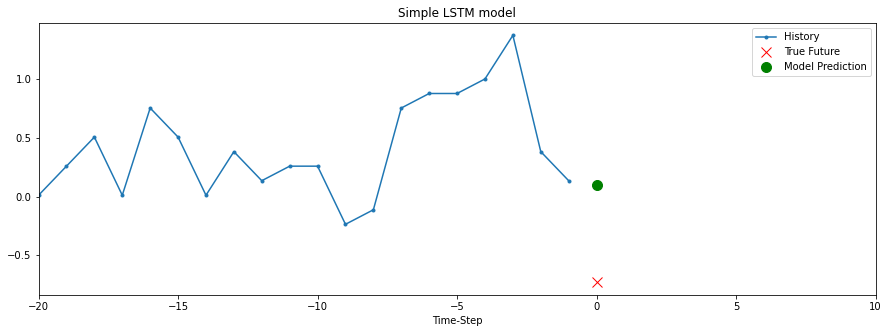

In [59]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      model.predict(x)[0]], 0, 'Simple LSTM model')

In [60]:
hourly.columns

Index(['wnd_speed', 'temp_change', 'hourly_liq_depth_dim', 'liq_depth_dim',
       'fan_speed', 'fan_speed2', 'fan_speed3', 'rh_air_temp', 'rel_humiditiy',
       'min_hourly_air_temp', 'max_hourly_air_temp', 'std_hourly_air_temp',
       'std_hourly_humidity', 'air_temp', 'air_temp_2', 'air_temp_3',
       'std_hourly_air_temp_2', 'std_hourly_air_temp_3', 'wet1', 'wet2',
       'solar_rad', 'min_solar_rad', 'max_solar_rad', 'std_solar_rad',
       'surface_temp', 'std_surface_temp', 'ex_air_temp', 'ex_air_temp_2',
       'hourly_gust', 'wind_std', 'hour'],
      dtype='object')

In [61]:
features_considered = ['wnd_speed', 'temp_change', 'rel_humiditiy','hourly_gust','surface_temp']

In [62]:
featuresLSTM = hourly[features_considered]
featuresLSTM.index = hourly.index
featuresLSTM.head()

,wnd_speed,temp_change,rel_humiditiy,hourly_gust,surface_temp
DATE,,,,,
2017-01-01 00:00:00,32,44,403,61,44
2017-01-01 01:00:00,25,42,417,49,42
2017-01-01 02:00:00,25,42,424,53,41
2017-01-01 03:00:00,27,39,428,56,39
2017-01-01 04:00:00,30,40,420,61,36


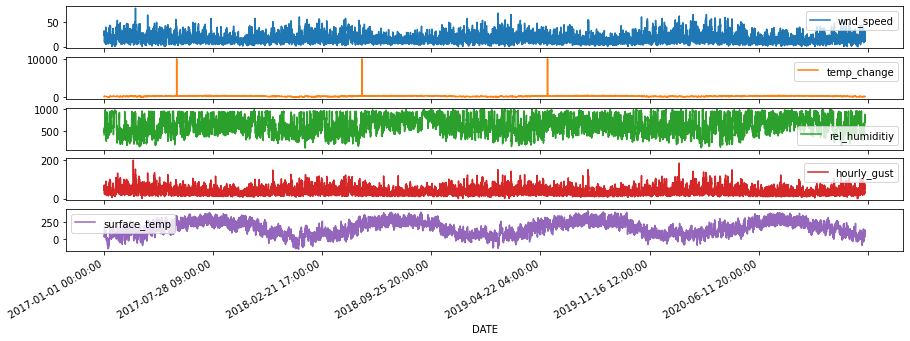

In [63]:
featuresLSTM.plot(subplots=True)
plt.show()

In [64]:
dataset = featuresLSTM.values
scaler = StandardScaler().fit(dataset[:train_split])
dataset = scaler.transform(dataset)

In [65]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [85]:
past_history = 72
future_target = 6
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   train_split, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               train_split, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [86]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (72, 5)


In [87]:
train_data_single = tf.data.Dataset.from_tensor_slices(
    (x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data_single = tf.data.Dataset.from_tensor_slices(
    (x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE)

In [88]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]),
    tf.keras.layers.Dense(1)
])


model2.compile(optimizer='adam', loss='mse')

In [89]:
for x, y in val_data_single.take(1):
    print(model2.predict(x).shape)

(256, 1)


In [90]:
tf.keras.backend.clear_session()

In [91]:
early2 = tf.keras.callbacks.EarlyStopping('val_loss', patience=5)

history2 = model2.fit(train_data_single, epochs=EPOCHS,
                    validation_data=val_data_single,
                    callbacks=[early2])

Epoch 1/200
98/98 [==============================] - 7s 60ms/step - loss: 0.9345 - val_loss: 0.0403
Epoch 2/200
98/98 [==============================] - 5s 53ms/step - loss: 0.9438 - val_loss: 0.0401
Epoch 3/200
98/98 [==============================] - 5s 52ms/step - loss: 0.5487 - val_loss: 0.0342
Epoch 4/200
98/98 [==============================] - 5s 52ms/step - loss: 1.0822 - val_loss: 0.0320
Epoch 5/200
98/98 [==============================] - 5s 53ms/step - loss: 0.7153 - val_loss: 0.0324
Epoch 6/200
98/98 [==============================] - 5s 52ms/step - loss: 0.5657 - val_loss: 0.0290
Epoch 7/200
98/98 [==============================] - 5s 52ms/step - loss: 0.8305 - val_loss: 0.0286
Epoch 8/200
98/98 [==============================] - 5s 53ms/step - loss: 1.0563 - val_loss: 0.0314
Epoch 9/200
98/98 [==============================] - 5s 53ms/step - loss: 0.4671 - val_loss: 0.0369
Epoch 10/200
98/98 [==============================] - 5s 53ms/step - loss: 0.4832 - val_loss: 0.0577

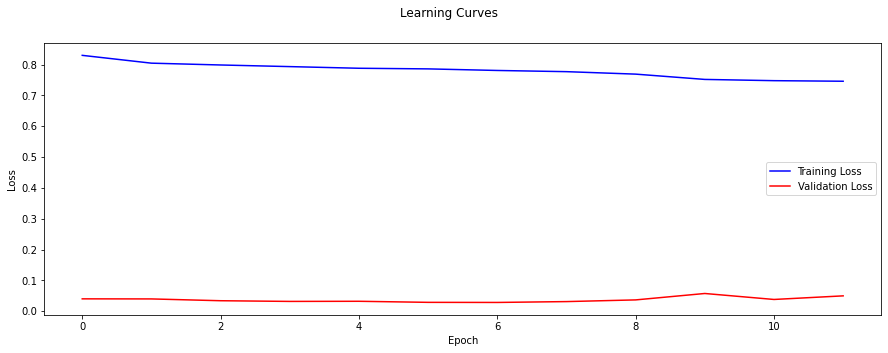

In [92]:
history_df = pd.DataFrame(history2.history)
history_df['epoch'] = history2.epoch
fig = plt.Figure(figsize=(15, 8))

epochs_to_mean = 1

plt.plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
plt.plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
plt.suptitle('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

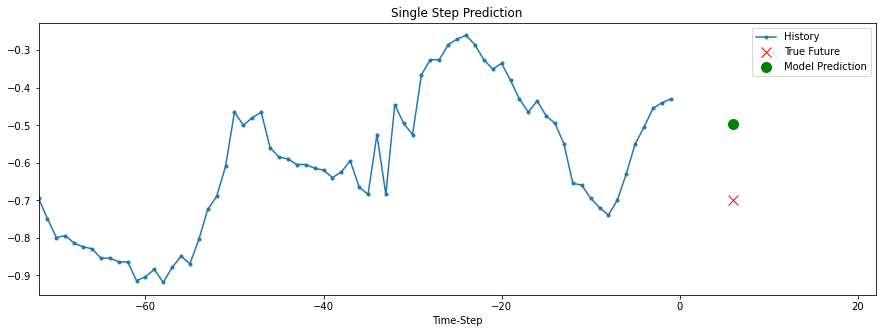

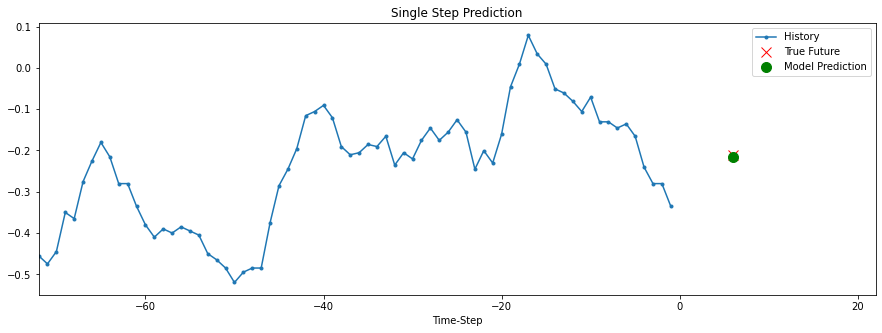

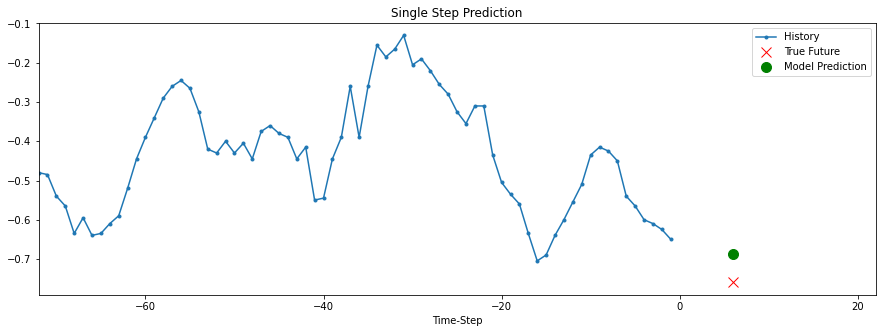

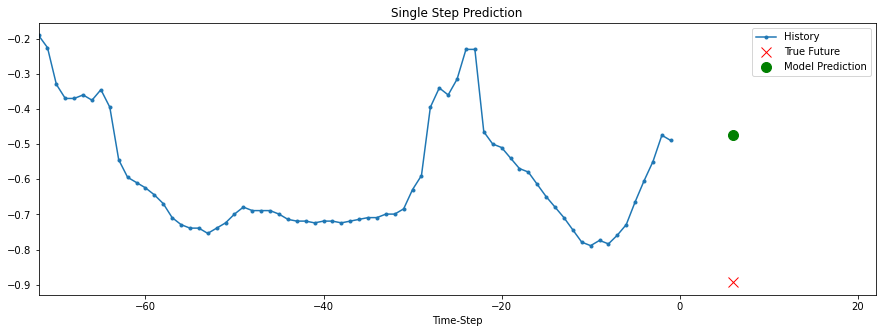

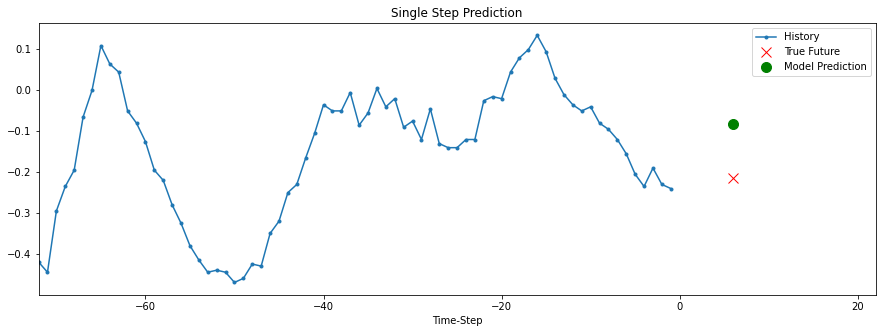

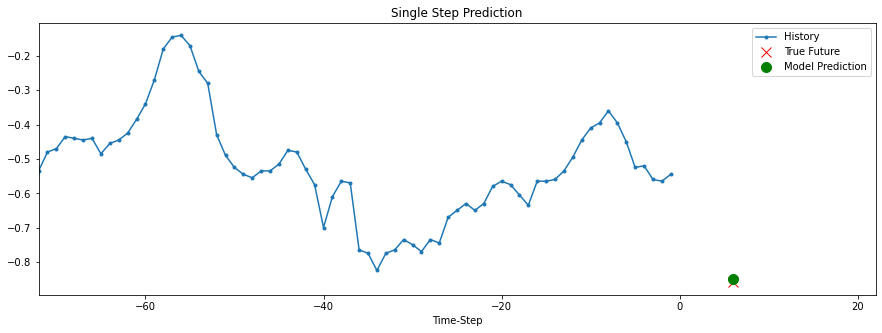

In [94]:
for x, y in val_data_single.take(6):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                      model2.predict(x)[0]], 6,
                     'Single Step Prediction')

In [96]:
future_target = 6
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             train_split, None, past_history,
                                             future_target, STEP)

In [97]:
print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (72, 5)

 Target temperature to predict : (6,)


In [98]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE)

In [100]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True,
                         input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.LSTM(16, dropout=0.2),
    tf.keras.layers.Dense(6),
])


model3.compile(
    optimizer=tf.keras.optimizers.Adam(), loss='mae')

In [102]:
early3 = tf.keras.callbacks.EarlyStopping('val_loss', patience=3)

history3 = model3.fit(train_data_multi, epochs=EPOCHS,
                    validation_data=val_data_multi,
                    callbacks=[early3])

Epoch 1/200
98/98 [==============================] - 8s 82ms/step - loss: 0.2154 - val_loss: 0.1402
Epoch 2/200
98/98 [==============================] - 7s 75ms/step - loss: 0.1512 - val_loss: 0.1142
Epoch 3/200
98/98 [==============================] - 7s 76ms/step - loss: 0.1212 - val_loss: 0.0918
Epoch 4/200
98/98 [==============================] - 7s 75ms/step - loss: 0.1061 - val_loss: 0.0811
Epoch 5/200
98/98 [==============================] - 7s 75ms/step - loss: 0.0983 - val_loss: 0.0770
Epoch 6/200
98/98 [==============================] - 7s 74ms/step - loss: 0.0937 - val_loss: 0.0730
Epoch 7/200
98/98 [==============================] - 8s 79ms/step - loss: 0.0914 - val_loss: 0.0730
Epoch 8/200
98/98 [==============================] - 7s 73ms/step - loss: 0.0897 - val_loss: 0.0703
Epoch 9/200
98/98 [==============================] - 7s 75ms/step - loss: 0.0879 - val_loss: 0.0680
Epoch 10/200
98/98 [==============================] - 7s 74ms/step - loss: 0.0868 - val_loss: 0.0680

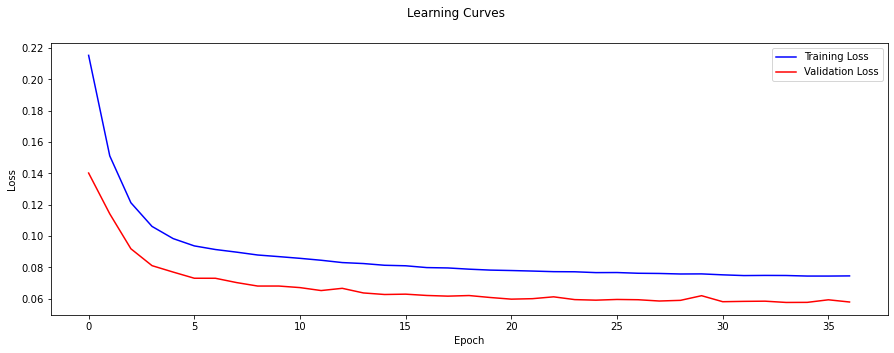

In [103]:
history_df = pd.DataFrame(history3.history)
history_df['epoch'] = history3.epoch
fig = plt.Figure(figsize=(15, 8))

epochs_to_mean = 1

plt.plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
plt.plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
plt.suptitle('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

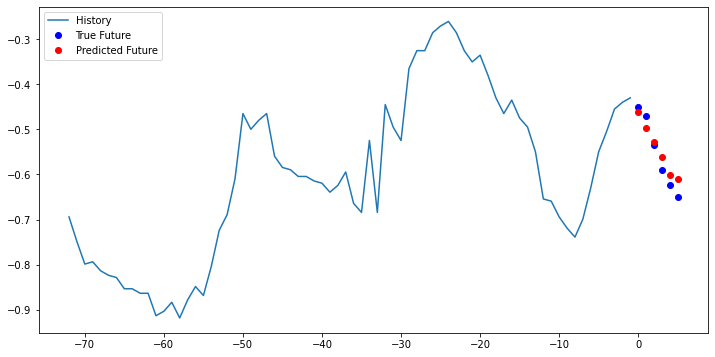

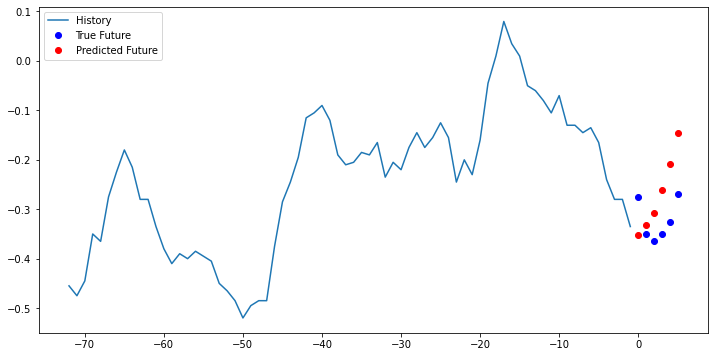

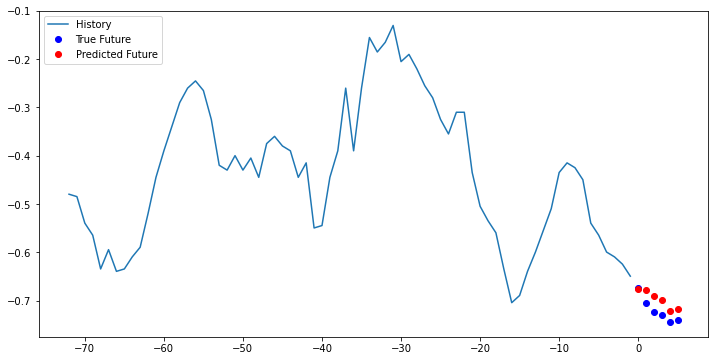

In [105]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], model3.predict(x)[0])

In [106]:
x_train_uni, y_train_uni = univariate_data(uni_data_scaled, 0, train_split,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data_scaled, train_split, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [107]:
modelCNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, 5, activation='relu', input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.MaxPooling1D(3),
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])

modelCNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16, 32)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 32)             5152      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [108]:
modelCNN.compile(optimizer='adam', loss='mae')
earlyCNN = tf.keras.callbacks.EarlyStopping('val_loss', patience=3)

historyCNN = modelCNN.fit(train_univariate, epochs=EPOCHS,
                    validation_data=val_univariate,
                    callbacks=[early])

Epoch 1/200
98/98 [==============================] - 3s 12ms/step - loss: 0.6836 - val_loss: 0.5738
Epoch 2/200
98/98 [==============================] - 0s 4ms/step - loss: 0.5519 - val_loss: 0.5565
Epoch 3/200
98/98 [==============================] - 0s 4ms/step - loss: 0.5307 - val_loss: 0.5476
Epoch 4/200
98/98 [==============================] - 0s 4ms/step - loss: 0.5256 - val_loss: 0.5418
Epoch 5/200
98/98 [==============================] - 0s 4ms/step - loss: 0.5215 - val_loss: 0.5408
Epoch 6/200
98/98 [==============================] - 0s 4ms/step - loss: 0.5200 - val_loss: 0.5376
Epoch 7/200
98/98 [==============================] - 0s 4ms/step - loss: 0.5133 - val_loss: 0.5366
Epoch 8/200
98/98 [==============================] - 0s 4ms/step - loss: 0.5164 - val_loss: 0.5429
Epoch 9/200
98/98 [==============================] - 0s 4ms/step - loss: 0.5136 - val_loss: 0.5429
Epoch 10/200
98/98 [==============================] - 0s 4ms/step - loss: 0.5192 - val_loss: 0.5351
Epoch 11

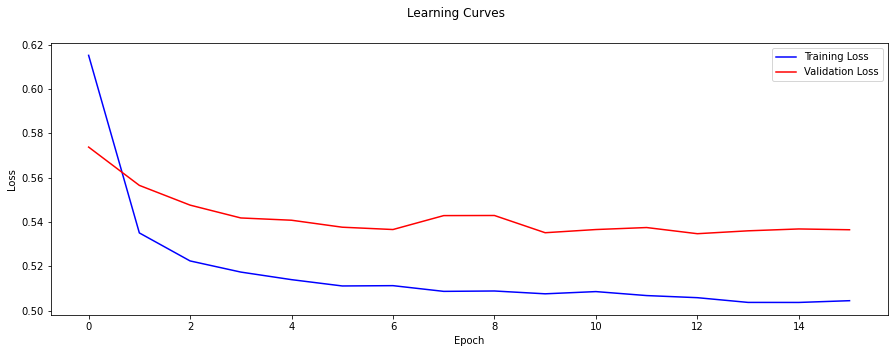

In [109]:
history_df = pd.DataFrame(historyCNN.history)
history_df['epoch'] = historyCNN.epoch
fig = plt.Figure(figsize=(15, 8))

epochs_to_mean = 1

plt.plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
plt.plot(history_df['val_loss'].rolling(epochs_to_mean).mean(), '-r')
plt.suptitle('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()